In [ ]:
# Optimisation Algorithms in Non-Convex Classification Problems with Adversarial Training

In [ ]:
# MINI-BATCH GRADIENT

In [ ]:
# Import data from MNIST

In [1]:
import torch
use_cuda = False # GPU seems to raise erros on my side
device = torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')
from data_utils import get_mnist, build_data_loaders
train_dataset, test_dataset = get_mnist(normalize=True)
train_dataset.data.mean(0).mean().item(), test_dataset.data.mean(0).mean().item()

(-7.328089801639237e-10, 0.002495675580576062)

In [ ]:

# Values should be (-7.328089801639237e-10, 0.002495675580576062) if the import was successful

In [ ]:
# Tuning Hyperparameters for Minibatch to ensure equitable comparision to the other algorithms tested
# Use the Ray Tune library to run Bayes Search on the following parameters:
# The learning rate
# The batch size
# Whether we have a decreasing learning rate or not

In [2]:
from ray import tune
from net import Net
import numpy as np 
import pandas
from minibatch import minibatch_run, minibatch_tune

In [3]:
from ray.tune.suggest.bayesopt import BayesOptSearch
space = {
            "lr": tune.uniform(1e-4, 1e-2),
            "b_size": tune.uniform(2, 128),
            "dec_lr": tune.uniform(0, 1)
        }
samples = 5 # Suggested value by the Ray Tune Docs

In [ ]:
# Note here that the neural net deployed here is found in the net.py file
# The Loss function throughout is simply Torch's CrossEntropyLoss
# Bayes Search here focuses on maximising the average accuracy (out of 100%)

In [4]:
tune_net = Net().to(device)
criterion = torch.nn.CrossEntropyLoss()
bayesopt = BayesOptSearch(metric="mean_accuracy", mode="max")

In [ ]:
# The tuning function is found in the minibatch.py file and based on the standard format for Ray Tune calls
# It stores the result of the 10 runs in a pandas dataframe and then returns the highest average accuracy and the associated parameters

In [5]:
best_config, best_result = minibatch_tune(tune_net, train_dataset, test_dataset, samples, criterion, space, bayesopt, device)

2021-05-23 16:41:25,386	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8266
2021-05-23 16:41:26,576	WARNING function_runner.py:544 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-05-23 16:41:26,581	WARNING bayesopt.py:390 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2021-05-23 16:41:26,582	WARNING bayesopt.py:390 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2021-05-23 16:41:26,582	WARNING bayesopt.py:390 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2021-05-23 16:41:26,616	WARNING tune.py:494 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1

Trial name,status,loc,b_size,dec_lr,lr
minibatch_build_f40225b6,PENDING,,49.1921,0.950714,0.00734674


(pid=14901) Launching training on cpu
(pid=14896) Launching training on cpu
(pid=14898) Launching training on cpu
(pid=14899) Launching training on cpu
(pid=14900) Launching training on cpu
(pid=14898) batch 100	loss = 2.277	acc = 0.3333
(pid=14898) batch 200	loss = 2.34	acc = 0.1111
(pid=14896) batch 100	loss = 2.337	acc = 0.04082
(pid=14898) batch 300	loss = 2.264	acc = 0.1111
(pid=14898) batch 400	loss = 2.305	acc = 0.0
(pid=14901) batch 100	loss = 2.28	acc = 0.1299
(pid=14898) batch 500	loss = 2.291	acc = 0.2222
(pid=14899) batch 100	loss = 1.926	acc = 0.6374
(pid=14896) batch 200	loss = 2.302	acc = 0.02041
(pid=14898) batch 600	loss = 2.3	acc = 0.0
(pid=14900) batch 100	loss = 2.262	acc = 0.2736
(pid=14898) batch 700	loss = 2.33	acc = 0.0
(pid=14898) batch 800	loss = 2.297	acc = 0.2222
(pid=14901) batch 200	loss = 2.247	acc = 0.4416
(pid=14898) batch 900	loss = 2.35	acc = 0.0
(pid=14896) batch 300	loss = 2.33	acc = 0.102
(pid=14898) batch 1000	loss = 2.286	acc = 0.1111
(pid=14898)

Trial name,status,loc,b_size,dec_lr,lr,acc,iter,total time (s)
minibatch_build_f40225b6,RUNNING,,49.1921,0.950714,0.00734674,,,
minibatch_build_f40225b7,RUNNING,,77.431,0.156019,0.00164435,,,
minibatch_build_f40225b8,RUNNING,,9.31854,0.866176,0.00605104,,,
minibatch_build_f40225b9,RUNNING,,91.2171,0.0205845,0.00970211,,,
minibatch_build_f40225ba,RUNNING,10.23.2.84:14900,106.888,0.212339,0.00190007,"[0.6792452830188679, 0.7358490566037735, 0.6415094339622641, 0.6886792452830188, 0.6320754716981132, 0.5943396226415094, 0.660377358490566, 0.7452830188679245, 0.6981132075471698, 0.6226415094339622, 0.5471698113207547, 0.6226415094339622, 0.6226415094339622, 0.5377358490566038, 0.6226415094339622, 0.6415094339622641, 0.6320754716981132, 0.6886792452830188, 0.6509433962264151, 0.6698113207547169, 0.6415094339622641, 0.6698113207547169, 0.5943396226415094, 0.660377358490566, 0.6320754716981132, 0.6037735849056604, 0.6698113207547169, 0.6037735849056604, 0.6886792452830188, 0.6886792452830188, 0.7169811320754716, 0.660377358490566, 0.5943396226415094, 0.5660377358490566, 0.6415094339622641, 0.5660377358490566, 0.5943396226415094, 0.6792452830188679, 0.6415094339622641, 0.6792452830188679, 0.5566037735849056, 0.6037735849056604, 0.6509433962264151, 0.7358490566037735, 0.6320754716981132, 0.6320754716981132, 0.6415094339622641, 0.6981132075471698, 0.7735849056603774, 0.6698113207547169, 0.8207547169811321, 0.7547169811320755, 0.6981132075471698, 0.8301886792452831, 0.7547169811320755, 0.6981132075471698, 0.6509433962264151, 0.6886792452830188, 0.7358490566037735, 0.839622641509434, 0.839622641509434, 0.7358490566037735, 0.6415094339622641, 0.6415094339622641, 0.6886792452830188, 0.6981132075471698, 0.7830188679245284, 0.7641509433962265, 0.6509433962264151, 0.7358490566037735, 0.6509433962264151, 0.7358490566037735, 0.7358490566037735, 0.7358490566037735, 0.6886792452830188, 0.7358490566037735, 0.7169811320754716, 0.7169811320754716, 0.7547169811320755, 0.7358490566037735, 0.7169811320754716, 0.8301886792452831, 0.9339622641509434, 0.9150943396226415, 0.7924528301886793, 0.6792452830188679, 0.7735849056603774, 0.7924528301886793, 0.7169811320754716, 0.7830188679245284, 0.7547169811320755, 0.6037735849056604, 0.6415094339622641, 0.6037735849056604, 0.75]",1,98.0926


(pid=14898) batch 3600	loss = 2.269	acc = 0.2222
(pid=14896) batch 1200	loss = 2.31	acc = 0.1429
(pid=14896) epoch 0	avg epoch loss = 2.3	avg epoch acc = 0.1084
(pid=14896) training took 102.3 s
(pid=14898) batch 3700	loss = 2.283	acc = 0.1111
Result for minibatch_build_f40225b9:
  date: 2021-05-23_16-43-12
  done: false
  experiment_id: 851768343efd4f1e8bfa9ba592a1ab07
  hostname: mfranke-MS-7818
  iterations_since_restore: 1
  mean_accuracy:
  - 0.978021978021978
  - 0.9560439560439561
  - 0.9010989010989011
  - 0.8351648351648352
  - 0.9010989010989011
  - 0.9010989010989011
  - 0.8241758241758241
  - 0.8901098901098901
  - 0.9230769230769231
  - 0.9230769230769231
  - 0.8681318681318682
  - 0.8901098901098901
  - 0.8681318681318682
  - 0.8131868131868132
  - 0.8791208791208791
  - 0.9230769230769231
  - 0.9010989010989011
  - 0.8571428571428571
  - 0.8791208791208791
  - 0.8901098901098901
  - 0.9230769230769231
  - 0.8681318681318682
  - 0.8681318681318682
  - 0.8351648351648352
 

Trial name,status,loc,b_size,dec_lr,lr,acc,iter,total time (s)
minibatch_build_f40225b6,RUNNING,,49.1921,0.950714,0.00734674,,,
minibatch_build_f40225b7,RUNNING,10.23.2.84:14901,77.431,0.156019,0.00164435,"[0.7142857142857143, 0.7792207792207793, 0.7272727272727273, 0.6233766233766234, 0.7792207792207793, 0.7142857142857143, 0.6233766233766234, 0.6363636363636364, 0.5974025974025974, 0.7272727272727273, 0.7792207792207793, 0.7662337662337663, 0.6753246753246753, 0.6623376623376623, 0.6363636363636364, 0.7532467532467533, 0.6103896103896104, 0.6623376623376623, 0.6493506493506493, 0.6103896103896104, 0.7402597402597403, 0.6623376623376623, 0.6233766233766234, 0.7662337662337663, 0.6623376623376623, 0.6753246753246753, 0.6753246753246753, 0.6493506493506493, 0.6623376623376623, 0.6883116883116883, 0.7662337662337663, 0.5714285714285714, 0.7402597402597403, 0.6363636363636364, 0.6753246753246753, 0.6753246753246753, 0.7012987012987013, 0.6753246753246753, 0.7272727272727273, 0.7012987012987013, 0.7402597402597403, 0.7402597402597403, 0.7532467532467533, 0.7012987012987013, 0.6753246753246753, 0.6233766233766234, 0.6233766233766234, 0.6883116883116883, 0.5194805194805194, 0.6233766233766234, 0.6233766233766234, 0.6883116883116883, 0.7012987012987013, 0.7142857142857143, 0.7402597402597403, 0.6233766233766234, 0.5974025974025974, 0.5714285714285714, 0.7402597402597403, 0.6883116883116883, 0.7402597402597403, 0.6883116883116883, 0.6103896103896104, 0.6883116883116883, 0.6493506493506493, 0.7402597402597403, 0.8181818181818182, 0.7662337662337663, 0.7272727272727273, 0.9090909090909091, 0.7922077922077922, 0.7402597402597403, 0.7532467532467533, 0.8571428571428571, 0.8181818181818182, 0.8181818181818182, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7792207792207793, 0.8311688311688312, 0.974025974025974, 0.8831168831168831, 0.8441558441558441, 0.8961038961038961, 0.5974025974025974, 0.7272727272727273, 0.6883116883116883, 0.7922077922077922, 0.6883116883116883, 0.7402597402597403, 0.8831168831168831, 0.8571428571428571, 0.7662337662337663, 0.7142857142857143, 0.7532467532467533, 0.7532467532467533, 0.6363636363636364, 0.7532467532467533, 0.8311688311688312, 0.8441558441558441, 0.7402597402597403, 0.7662337662337663, 0.8181818181818182, 0.7792207792207793, 0.7922077922077922, 0.8571428571428571, 0.8571428571428571, 0.8311688311688312, 0.7662337662337663, 0.7922077922077922, 0.8441558441558441, 0.8961038961038961, 0.961038961038961, 0.935064935064935, 0.935064935064935, 0.8831168831168831, 0.6883116883116883, 0.8181818181818182, 0.7922077922077922, 0.8181818181818182, 0.8571428571428571, 0.8051948051948052, 0.8311688311688312, 0.7792207792207793, 0.6753246753246753, 0.6363636363636364, 0.7142857142857143, 0.6103896103896104, 0.746268656716418]",1,104.508
minibatch_build_f40225b8,RUNNING,,9.31854,0.866176,0.00605104,,,
minibatch_build_f40225b9,RUNNING,10.23.2.84:14899,91.2171,0.0205845,0.00970211,"[0.978021978021978, 0.9560439560439561, 0.9010989010989011, 0.8351648351648352, 0.9010989010989011, 0.9010989010989011, 0.8241758241758241, 0.8901098901098901, 0.9230769230769231, 0.9230769230769231, 0.8681318681318682, 0.8901098901098901, 0.8681318681318682, 0.8131868131868132, 0.8791208791208791, 0.9230769230769231, 0.9010989010989011, 0.8571428571428571, 0.8791208791208791, 0.8901098901098901, 0.9230769230769231, 0.8681318681318682, 0.8681318681318682, 0.8351648351648352, 0.9120879120879121, 0.9340659340659341, 0.8131868131868132, 0.9560439560439561, 0.8901098901098901, 0.9230769230769231, 0.8791208791208791, 0.8681318681318682, 0.9340659340659341, 0.9010989010989011, 0.8791208791208791, 0.8791208791208791, 0.8571428571428571, 0.8901098901098901, 0.8791208791208791, 0.8461538461538461, 0.9340659340659341, 0.7802197802197802, 0.8461538461538461, 0.9120879120879121, 0.9010989010989011, 0.8901098901098901, 0.8571428571428571, 0.9010989010989011, 0.8901098901098901, 0.945054945054945, 0.8901098901098901, 0.9120879120879121, 0.8

- 0.2222222222222222
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.0
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.0
  - 0.2222222222222222
  - 0.0
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.0
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.0
  - 0.4444444444444444
  - 0.2222222222222222
  - 0.22222222222

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,RUNNING,10.23.2.84:14896,49.1921,0.950714,0.00734674,1,109.143
minibatch_build_f40225b7,RUNNING,10.23.2.84:14901,77.431,0.156019,0.00164435,1,104.508
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,1,194.051
minibatch_build_f40225b9,RUNNING,10.23.2.84:14899,91.2171,0.0205845,0.00970211,1,103.258
minibatch_build_f40225ba,RUNNING,10.23.2.84:14900,106.888,0.212339,0.00190007,1,98.0926


(pid=14899) epoch 0	avg epoch loss = 0.2019	avg epoch acc = 0.9406
(pid=14899) training took 92.65 s
Result for minibatch_build_f40225ba:
  date: 2021-05-23_16-44-45
  done: false
  experiment_id: d87c3d03789b4da3bf23a84ce80e0ed6
  hostname: mfranke-MS-7818
  iterations_since_restore: 2
  mean_accuracy:
  - 0.8867924528301887
  - 0.8773584905660378
  - 0.839622641509434
  - 0.839622641509434
  - 0.7641509433962265
  - 0.7641509433962265
  - 0.8207547169811321
  - 0.9056603773584906
  - 0.8490566037735849
  - 0.8490566037735849
  - 0.7735849056603774
  - 0.7358490566037735
  - 0.8113207547169812
  - 0.7547169811320755
  - 0.839622641509434
  - 0.8018867924528302
  - 0.8679245283018868
  - 0.8584905660377359
  - 0.839622641509434
  - 0.7830188679245284
  - 0.7641509433962265
  - 0.8490566037735849
  - 0.7735849056603774
  - 0.8490566037735849
  - 0.8207547169811321
  - 0.8018867924528302
  - 0.839622641509434
  - 0.839622641509434
  - 0.8113207547169812
  - 0.8301886792452831
  - 0.84905

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,RUNNING,10.23.2.84:14896,49.1921,0.950714,0.00734674,1,109.143
minibatch_build_f40225b7,RUNNING,10.23.2.84:14901,77.431,0.156019,0.00164435,1,104.508
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,1,194.051
minibatch_build_f40225b9,RUNNING,10.23.2.84:14899,91.2171,0.0205845,0.00970211,2,201.329
minibatch_build_f40225ba,RUNNING,10.23.2.84:14900,106.888,0.212339,0.00190007,2,196.441


(pid=14898) batch 300	loss = 2.261	acc = 0.2222
Result for minibatch_build_f40225b7:
(pid=14898) batch 400	loss = 2.3	acc = 0.0
  date: 2021-05-23_16-44-54
  done: false
  experiment_id: 6032c7cf819b4a5d89bca275b9da2c46
  hostname: mfranke-MS-7818
  iterations_since_restore: 2
  mean_accuracy:
  - 0.8961038961038961
  - 0.8831168831168831
  - 0.8961038961038961
  - 0.8441558441558441
  - 0.8311688311688312
  - 0.8441558441558441
  - 0.8571428571428571
  - 0.7662337662337663
  - 0.8701298701298701
  - 0.8571428571428571
  - 0.922077922077922
  - 0.922077922077922
  - 0.8051948051948052
  - 0.8441558441558441
  - 0.7792207792207793
  - 0.7922077922077922
  - 0.7922077922077922
  - 0.8051948051948052
  - 0.8311688311688312
  - 0.8181818181818182
  - 0.8181818181818182
  - 0.8441558441558441
  - 0.8571428571428571
  - 0.8571428571428571
  - 0.8571428571428571
  - 0.8311688311688312
  - 0.7922077922077922
  - 0.7792207792207793
  - 0.8051948051948052
  - 0.8571428571428571
  - 0.87012987012

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,RUNNING,10.23.2.84:14896,49.1921,0.950714,0.00734674,2,218.301
minibatch_build_f40225b7,RUNNING,10.23.2.84:14901,77.431,0.156019,0.00164435,2,206.359
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,1,194.051
minibatch_build_f40225b9,RUNNING,10.23.2.84:14899,91.2171,0.0205845,0.00970211,2,201.329
minibatch_build_f40225ba,RUNNING,10.23.2.84:14900,106.888,0.212339,0.00190007,2,196.441


(pid=14901) batch 100	loss = 0.5449	acc = 0.8961
(pid=14898) batch 900	loss = 2.343	acc = 0.0
(pid=14898) batch 1000	loss = 2.284	acc = 0.2222
(pid=14896) batch 100	loss = 2.328	acc = 0.06122
(pid=14898) batch 1100	loss = 2.297	acc = 0.1111
(pid=14900) batch 200	loss = 0.4342	acc = 0.8774
(pid=14898) batch 1200	loss = 2.321	acc = 0.0
(pid=14901) batch 200	loss = 0.454	acc = 0.9221
(pid=14899) batch 200	loss = 0.07288	acc = 0.978
(pid=14898) batch 1300	loss = 2.312	acc = 0.2222
(pid=14896) batch 200	loss = 2.298	acc = 0.06122
(pid=14898) batch 1400	loss = 2.317	acc = 0.1111
(pid=14898) batch 1500	loss = 2.335	acc = 0.0
(pid=14898) batch 1600	loss = 2.312	acc = 0.1111
(pid=14901) batch 300	loss = 0.4392	acc = 0.8831
(pid=14898) batch 1700	loss = 2.244	acc = 0.3333
(pid=14896) batch 300	loss = 2.326	acc = 0.102
(pid=14900) batch 300	loss = 0.6576	acc = 0.8208
(pid=14898) batch 1800	loss = 2.284	acc = 0.1111
(pid=14899) batch 300	loss = 0.2002	acc = 0.9231
(pid=14898) batch 1900	loss = 2.3

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,RUNNING,10.23.2.84:14896,49.1921,0.950714,0.00734674,2,218.301
minibatch_build_f40225b7,RUNNING,10.23.2.84:14901,77.431,0.156019,0.00164435,2,206.359
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,1,194.051
minibatch_build_f40225b9,RUNNING,10.23.2.84:14899,91.2171,0.0205845,0.00970211,2,201.329
minibatch_build_f40225ba,RUNNING,10.23.2.84:14900,106.888,0.212339,0.00190007,3,295.115


(pid=14896) batch 900	loss = 2.313	acc = 0.08163
(pid=14898) batch 3600	loss = 2.269	acc = 0.2222
(pid=14899) epoch 0	avg epoch loss = 0.1343	avg epoch acc = 0.9603
(pid=14899) training took 97.84 s
(pid=14898) batch 3700	loss = 2.281	acc = 0.2222
(pid=14901) epoch 0	avg epoch loss = 0.4098	avg epoch acc = 0.8873
(pid=14901) training took 96.98 s
(pid=14898) batch 3800	loss = 2.311	acc = 0.0
Result for minibatch_build_f40225b9:
  date: 2021-05-23_16-46-33
  done: false
  experiment_id: 851768343efd4f1e8bfa9ba592a1ab07
  hostname: mfranke-MS-7818
  iterations_since_restore: 3
  mean_accuracy:
  - 0.989010989010989
  - 0.989010989010989
  - 0.9560439560439561
  - 0.945054945054945
  - 0.978021978021978
  - 0.9560439560439561
  - 0.9560439560439561
  - 0.9120879120879121
  - 0.978021978021978
  - 0.967032967032967
  - 0.9560439560439561
  - 0.945054945054945
  - 0.9230769230769231
  - 0.9340659340659341
  - 0.9230769230769231
  - 0.978021978021978
  - 0.945054945054945
  - 0.9450549450549

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,RUNNING,10.23.2.84:14896,49.1921,0.950714,0.00734674,2,218.301
minibatch_build_f40225b7,RUNNING,10.23.2.84:14901,77.431,0.156019,0.00164435,2,206.359
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,1,194.051
minibatch_build_f40225b9,RUNNING,10.23.2.84:14899,91.2171,0.0205845,0.00970211,3,304.549
minibatch_build_f40225ba,RUNNING,10.23.2.84:14900,106.888,0.212339,0.00190007,3,295.115


(pid=14898) batch 3900	loss = 2.289	acc = 0.2222
(pid=14896) batch 1000	loss = 2.285	acc = 0.1429
Result for minibatch_build_f40225b7:
  date: 2021-05-23_16-46-37
  done: false
  experiment_id: 6032c7cf819b4a5d89bca275b9da2c46
  hostname: mfranke-MS-7818
  iterations_since_restore: 3
  mean_accuracy:
  - 0.948051948051948
  - 0.8961038961038961
  - 0.961038961038961
  - 0.8441558441558441
  - 0.8831168831168831
  - 0.8831168831168831
  - 0.9090909090909091
  - 0.7922077922077922
  - 0.8831168831168831
  - 0.8961038961038961
  - 0.935064935064935
  - 0.922077922077922
  - 0.8181818181818182
  - 0.8311688311688312
  - 0.8311688311688312
  - 0.8441558441558441
  - 0.8051948051948052
  - 0.8571428571428571
  - 0.8961038961038961
  - 0.8571428571428571
  - 0.8311688311688312
  - 0.8831168831168831
  - 0.8571428571428571
  - 0.8701298701298701
  - 0.8831168831168831
  - 0.8571428571428571
  - 0.8311688311688312
  - 0.8311688311688312
  - 0.8831168831168831
  - 0.9090909090909091
  - 0.883116

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,RUNNING,10.23.2.84:14896,49.1921,0.950714,0.00734674,3,331.719
minibatch_build_f40225b7,RUNNING,10.23.2.84:14901,77.431,0.156019,0.00164435,3,308.928
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,1,194.051
minibatch_build_f40225b9,RUNNING,10.23.2.84:14899,91.2171,0.0205845,0.00970211,3,304.549
minibatch_build_f40225ba,RUNNING,10.23.2.84:14900,106.888,0.212339,0.00190007,3,295.115


22
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.0
  - 0.2222222222222222
  - 0.0
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.1111111111111111
  - 0.4444444444444444
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.0
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.0
  - 0.4444444444444444
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.6666666666666666
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,RUNNING,10.23.2.84:14896,49.1921,0.950714,0.00734674,3,331.719
minibatch_build_f40225b7,RUNNING,10.23.2.84:14901,77.431,0.156019,0.00164435,3,308.928
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,2,391.999
minibatch_build_f40225b9,RUNNING,10.23.2.84:14899,91.2171,0.0205845,0.00970211,3,304.549
minibatch_build_f40225ba,RUNNING,10.23.2.84:14900,106.888,0.212339,0.00190007,3,295.115


(pid=14899) batch 600	loss = 0.08698	acc = 0.967
(pid=14898) batch 100	loss = 2.273	acc = 0.3333
Result for minibatch_build_f40225ba:
  date: 2021-05-23_16-48-03
  done: false
  experiment_id: d87c3d03789b4da3bf23a84ce80e0ed6
  hostname: mfranke-MS-7818
  iterations_since_restore: 4
  mean_accuracy:
  - 0.9245283018867925
  - 0.9433962264150944
  - 0.8962264150943396
  - 0.8962264150943396
  - 0.8773584905660378
  - 0.8301886792452831
  - 0.9056603773584906
  - 0.9433962264150944
  - 0.8962264150943396
  - 0.8867924528301887
  - 0.8867924528301887
  - 0.7830188679245284
  - 0.8867924528301887
  - 0.8867924528301887
  - 0.8584905660377359
  - 0.8773584905660378
  - 0.8679245283018868
  - 0.8962264150943396
  - 0.9056603773584906
  - 0.8584905660377359
  - 0.8679245283018868
  - 0.9245283018867925
  - 0.8773584905660378
  - 0.9150943396226415
  - 0.8773584905660378
  - 0.8962264150943396
  - 0.8962264150943396
  - 0.8584905660377359
  - 0.9056603773584906
  - 0.8773584905660378
  - 0.924

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,RUNNING,10.23.2.84:14896,49.1921,0.950714,0.00734674,3,331.719
minibatch_build_f40225b7,RUNNING,10.23.2.84:14901,77.431,0.156019,0.00164435,3,308.928
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,2,391.999
minibatch_build_f40225b9,RUNNING,10.23.2.84:14899,91.2171,0.0205845,0.00970211,4,407.812
minibatch_build_f40225ba,RUNNING,10.23.2.84:14900,106.888,0.212339,0.00190007,4,394.403


(pid=14898) batch 600	loss = 2.293	acc = 0.0
Result for minibatch_build_f40225b7:
(pid=14901) Avg loss = 0.2794665595373282	Avg acc = 0.9166788435445151
  date: 2021-05-23_16-48-19
  done: false
  experiment_id: 6032c7cf819b4a5d89bca275b9da2c46
  hostname: mfranke-MS-7818
  iterations_since_restore: 4
  mean_accuracy:
  - 0.961038961038961
  - 0.922077922077922
  - 0.961038961038961
  - 0.8831168831168831
  - 0.8831168831168831
  - 0.8961038961038961
  - 0.935064935064935
  - 0.8051948051948052
  - 0.8831168831168831
  - 0.9090909090909091
  - 0.948051948051948
  - 0.961038961038961
  - 0.8311688311688312
  - 0.8831168831168831
  - 0.8831168831168831
  - 0.8701298701298701
  - 0.8181818181818182
  - 0.8961038961038961
  - 0.922077922077922
  - 0.8831168831168831
  - 0.8831168831168831
  - 0.8961038961038961
  - 0.8701298701298701
  - 0.8831168831168831
  - 0.9090909090909091
  - 0.8831168831168831
  - 0.8701298701298701
  - 0.8701298701298701
  - 0.8831168831168831
  - 0.92207792207792

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,RUNNING,10.23.2.84:14896,49.1921,0.950714,0.00734674,4,443.845
minibatch_build_f40225b7,RUNNING,10.23.2.84:14901,77.431,0.156019,0.00164435,4,411.269
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,2,391.999
minibatch_build_f40225b9,RUNNING,10.23.2.84:14899,91.2171,0.0205845,0.00970211,4,407.812
minibatch_build_f40225ba,RUNNING,10.23.2.84:14900,106.888,0.212339,0.00190007,4,394.403


(pid=14900) batch 300	loss = 0.4894	acc = 0.8491
(pid=14898) batch 1900	loss = 2.311	acc = 0.1111
(pid=14898) batch 2000	loss = 2.348	acc = 0.1111
(pid=14901) batch 300	loss = 0.2832	acc = 0.9221
(pid=14896) batch 100	loss = 2.326	acc = 0.06122
(pid=14899) batch 300	loss = 0.1375	acc = 0.967
(pid=14898) batch 2100	loss = 2.288	acc = 0.1111
(pid=14898) batch 2200	loss = 2.309	acc = 0.1111
(pid=14898) batch 2300	loss = 2.273	acc = 0.1111
(pid=14896) batch 200	loss = 2.297	acc = 0.06122
(pid=14898) batch 2400	loss = 2.319	acc = 0.1111
(pid=14900) batch 400	loss = 0.3399	acc = 0.8962
(pid=14901) batch 400	loss = 0.2463	acc = 0.8961
(pid=14898) batch 2500	loss = 2.29	acc = 0.0
(pid=14898) batch 2600	loss = 2.282	acc = 0.1111
(pid=14899) batch 400	loss = 0.04344	acc = 0.989
(pid=14898) batch 2700	loss = 2.247	acc = 0.3333
(pid=14896) batch 300	loss = 2.325	acc = 0.1224
(pid=14898) batch 2800	loss = 2.27	acc = 0.3333
(pid=14898) batch 2900	loss = 2.27	acc = 0.2222
(pid=14901) batch 500	loss =

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,RUNNING,10.23.2.84:14896,49.1921,0.950714,0.00734674,4,443.845
minibatch_build_f40225b7,RUNNING,10.23.2.84:14901,77.431,0.156019,0.00164435,4,411.269
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,2,391.999
minibatch_build_f40225b9,RUNNING,10.23.2.84:14899,91.2171,0.0205845,0.00970211,4,407.812
minibatch_build_f40225ba,RUNNING,10.23.2.84:14900,106.888,0.212339,0.00190007,5,495.994


Result for minibatch_build_f40225ba:
  date: 2021-05-23_16-49-45
  done: true
  experiment_id: d87c3d03789b4da3bf23a84ce80e0ed6
  experiment_tag: 5_b_size=106.89,dec_lr=0.21234,lr=0.0019001
  hostname: mfranke-MS-7818
  iterations_since_restore: 5
  mean_accuracy:
  - 0.9245283018867925
  - 0.9622641509433962
  - 0.9245283018867925
  - 0.8962264150943396
  - 0.8867924528301887
  - 0.8490566037735849
  - 0.9056603773584906
  - 0.9528301886792453
  - 0.9056603773584906
  - 0.8962264150943396
  - 0.8962264150943396
  - 0.7924528301886793
  - 0.9056603773584906
  - 0.9056603773584906
  - 0.9056603773584906
  - 0.8962264150943396
  - 0.8773584905660378
  - 0.9150943396226415
  - 0.9056603773584906
  - 0.8584905660377359
  - 0.8679245283018868
  - 0.9245283018867925
  - 0.8867924528301887
  - 0.9433962264150944
  - 0.8962264150943396
  - 0.9150943396226415
  - 0.9245283018867925
  - 0.8962264150943396
  - 0.9150943396226415
  - 0.8962264150943396
  - 0.9150943396226415
  - 0.9056603773584906

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,RUNNING,10.23.2.84:14896,49.1921,0.950714,0.00734674,4,443.845
minibatch_build_f40225b7,RUNNING,10.23.2.84:14901,77.431,0.156019,0.00164435,4,411.269
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,2,391.999
minibatch_build_f40225b9,RUNNING,10.23.2.84:14899,91.2171,0.0205845,0.00970211,5,508.276
minibatch_build_f40225ba,TERMINATED,,106.888,0.212339,0.00190007,5,495.994


Result for minibatch_build_f40225b9:
(pid=14898) batch 4200	loss = 2.245	acc = 0.3333
  date: 2021-05-23_16-49-57
  done: true
  experiment_id: 851768343efd4f1e8bfa9ba592a1ab07
  experiment_tag: 4_b_size=91.217,dec_lr=0.020584,lr=0.0097021
  hostname: mfranke-MS-7818
  iterations_since_restore: 5
  mean_accuracy:
  - 1.0
  - 0.989010989010989
  - 0.967032967032967
  - 0.9560439560439561
  - 0.989010989010989
  - 0.989010989010989
  - 0.978021978021978
  - 0.945054945054945
  - 0.978021978021978
  - 0.978021978021978
  - 0.967032967032967
  - 0.967032967032967
  - 0.9560439560439561
  - 0.967032967032967
  - 0.9340659340659341
  - 0.989010989010989
  - 0.9560439560439561
  - 0.967032967032967
  - 0.945054945054945
  - 0.967032967032967
  - 0.967032967032967
  - 0.989010989010989
  - 0.9230769230769231
  - 0.9230769230769231
  - 0.978021978021978
  - 0.978021978021978
  - 0.9230769230769231
  - 0.978021978021978
  - 0.989010989010989
  - 0.989010989010989
  - 0.989010989010989
  - 0.9780

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,RUNNING,10.23.2.84:14896,49.1921,0.950714,0.00734674,4,443.845
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,2,391.999
minibatch_build_f40225b7,TERMINATED,,77.431,0.156019,0.00164435,5,513.949
minibatch_build_f40225b9,TERMINATED,,91.2171,0.0205845,0.00970211,5,508.276
minibatch_build_f40225ba,TERMINATED,,106.888,0.212339,0.00190007,5,495.994


(pid=14898) batch 4500	loss = 2.325	acc = 0.1111
(pid=14896) batch 900	loss = 2.312	acc = 0.08163
(pid=14898) batch 4600	loss = 2.282	acc = 0.1111
(pid=14898) batch 4700	loss = 2.32	acc = 0.0
(pid=14898) batch 4800	loss = 2.271	acc = 0.1111
(pid=14896) batch 1000	loss = 2.285	acc = 0.1429
(pid=14898) batch 4900	loss = 2.284	acc = 0.1111
(pid=14898) batch 5000	loss = 2.268	acc = 0.1111
(pid=14898) batch 5100	loss = 2.252	acc = 0.3333
(pid=14898) batch 5200	loss = 2.267	acc = 0.1111
(pid=14896) batch 1100	loss = 2.284	acc = 0.1837
(pid=14898) batch 5300	loss = 2.328	acc = 0.0
(pid=14898) batch 5400	loss = 2.315	acc = 0.1111
(pid=14898) batch 5500	loss = 2.306	acc = 0.0
(pid=14896) batch 1200	loss = 2.307	acc = 0.1429
(pid=14898) batch 5600	loss = 2.256	acc = 0.3333
(pid=14896) epoch 0	avg epoch loss = 2.296	avg epoch acc = 0.1229
(pid=14896) training took 85.1 s
(pid=14898) batch 5700	loss = 2.31	acc = 0.2222
(pid=14898) batch 5800	loss = 2.332	acc = 0.2222
Result for minibatch_build_f40

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,RUNNING,10.23.2.84:14896,49.1921,0.950714,0.00734674,5,532.05
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,2,391.999
minibatch_build_f40225b7,TERMINATED,,77.431,0.156019,0.00164435,5,513.949
minibatch_build_f40225b9,TERMINATED,,91.2171,0.0205845,0.00970211,5,508.276
minibatch_build_f40225ba,TERMINATED,,106.888,0.212339,0.00190007,5,495.994


.1111111111111111
  - 0.0
  - 0.0
  - 0.2222222222222222
  - 0.0
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.1111111111111111
  - 0.4444444444444444
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.0
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.0
  - 0.4444444444444444
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.6666666666666666
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.0
  - 0.2222222222222222
  - 0.0
  - 0.1111111111111111
  - 

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,3,541.448
minibatch_build_f40225b6,TERMINATED,,49.1921,0.950714,0.00734674,5,532.05
minibatch_build_f40225b7,TERMINATED,,77.431,0.156019,0.00164435,5,513.949
minibatch_build_f40225b9,TERMINATED,,91.2171,0.0205845,0.00970211,5,508.276
minibatch_build_f40225ba,TERMINATED,,106.888,0.212339,0.00190007,5,495.994



  - 0.0
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.1111111111111111
  - 0.4444444444444444
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.0
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.0
  - 0.4444444444444444
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.6666666666666666
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.0
  - 0.2222222222222222
  - 0.0
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.0
  - 0.

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,4,606.277
minibatch_build_f40225b6,TERMINATED,,49.1921,0.950714,0.00734674,5,532.05
minibatch_build_f40225b7,TERMINATED,,77.431,0.156019,0.00164435,5,513.949
minibatch_build_f40225b9,TERMINATED,,91.2171,0.0205845,0.00970211,5,508.276
minibatch_build_f40225ba,TERMINATED,,106.888,0.212339,0.00190007,5,495.994



  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.4444444444444444
  - 0.1111111111111111
  - 0.4444444444444444
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.0
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.0
  - 0.4444444444444444
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.6666666666666666
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.0
  - 0.2222222222222222
  - 0.0
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.0
  - 0.3333333333333333
  - 0.1111111111111111
  - 0.2222222222222222

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b8,RUNNING,10.23.2.84:14898,9.31854,0.866176,0.00605104,5,671.226
minibatch_build_f40225b6,TERMINATED,,49.1921,0.950714,0.00734674,5,532.05
minibatch_build_f40225b7,TERMINATED,,77.431,0.156019,0.00164435,5,513.949
minibatch_build_f40225b9,TERMINATED,,91.2171,0.0205845,0.00970211,5,508.276
minibatch_build_f40225ba,TERMINATED,,106.888,0.212339,0.00190007,5,495.994



  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.4444444444444444
  - 0.1111111111111111
  - 0.4444444444444444
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.0
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.0
  - 0.0
  - 0.4444444444444444
  - 0.2222222222222222
  - 0.2222222222222222
  - 0.3333333333333333
  - 0.0
  - 0.1111111111111111
  - 0.1111111111111111
  - 0.6666666666666666
  - 0.1111111111111111
  - 0.2222222222222222
  - 0.0
  - 0.2222222222222222
  - 0.0
  - 0.1111111111111111
  - 0.3333333333333333
  - 0.2222222222222222
  - 0.0
  - 0.3333333333333333
  - 0.1111111111111111
  - 0.2222222222222222

Trial name,status,loc,b_size,dec_lr,lr,iter,total time (s)
minibatch_build_f40225b6,TERMINATED,,49.1921,0.950714,0.00734674,5,532.05
minibatch_build_f40225b7,TERMINATED,,77.431,0.156019,0.00164435,5,513.949
minibatch_build_f40225b8,TERMINATED,,9.31854,0.866176,0.00605104,5,671.226
minibatch_build_f40225b9,TERMINATED,,91.2171,0.0205845,0.00970211,5,508.276
minibatch_build_f40225ba,TERMINATED,,106.888,0.212339,0.00190007,5,495.994


2021-05-23 16:52:39,900	INFO tune.py:549 -- Total run time: 673.33 seconds (673.14 seconds for the tuning loop).


In [6]:
best_config

{'b_size': 91.21714480230173,
 'dec_lr': 0.020584494295802447,
 'lr': 0.009702107536403744}

In [16]:
epochs = 10
batch_size = 91
learning_rate = 0.01
decreasing_lr = False

In [7]:
epochs = 10
batch_size = int(best_config["b_size"])
learning_rate = best_config["lr"]
decreasing_lr = best_config["dec_lr"]

In [8]:
if decreasing_lr < 0.5:
    print("Best Result was {:.2f}% with a Batch Size of {} and a fixed learning rate of {:.4f}".format(best_result*100, batch_size, learning_rate))
else:
    print("Best Result was {:.2f}% with a Batch Size of {} and a learning rate of {:.4f} that was decreasing".format(best_result*100, batch_size, learning_rate))

Best Result was 97.49% with a Batch Size of 91 and a fixed learning rate of 0.0097


In [ ]:
# Training and Testing under Normal Conditions

In [17]:
net_naive = Net().to(device)
train_loader, test_loader = build_data_loaders(train_dataset, test_dataset, batch_size)
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([91, 1, 1, 28, 28]) torch.Size([91])


In [ ]:
### Test the setup with the Minibatch Optimiser from the minibatch.py file
### Accuracy here is the percentage of correctly guessed labels

In [18]:
from training import training, testing, accuracy
from minibatch import MiniBatchOptimizer

mini_opt = MiniBatchOptimizer(net_naive.parameters(), lr=learning_rate, decreasing_lr=decreasing_lr)

In [13]:
import matplotlib.pyplot as plt

In [19]:
losses, acc = training(net_naive, train_loader, mini_opt, criterion, accuracy, epochs=epochs, device=device)

Launching training on cpu


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [20, 1, 5, 5], but got 5-dimensional input of size [91, 1, 1, 28, 28] instead

Avg loss = 2.2873311172832143	Avg acc = 0.1772462105795439


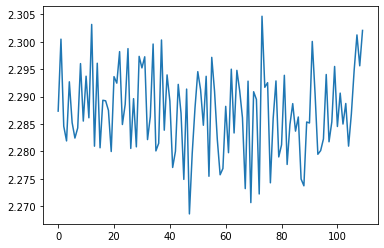

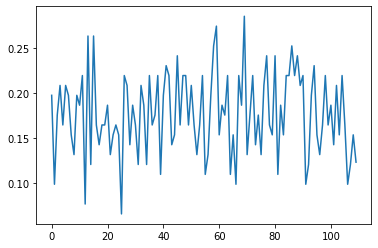

In [14]:
losses, acc = testing(net_naive, test_loader, criterion, accuracy, device=device)
plt.plot(losses)
plt.show()
plt.plot(acc)
plt.show()

In [ ]:
#net_compact = Net().to(device)

In [ ]:
# losses, accs = minibatch_run(net_compact, train_dataset, test_dataset, criterion, accuracy, device=device, bz=batch_size, lr=learning_rate, epochs=epochs, dec_lr=decreasing_lr)
# Has the weird shaping issue

In [ ]:
## Plot of losses

In [ ]:
plt.plot(losses)
plt.show()
plt.plot(acc)
plt.show()

In [ ]:
# Attack against Unprotected Model

In [ ]:
from adversary import attack, protect

In [ ]:
accuracies_lenet= []
examples_lenet = []

epsilons_lenet = np.arange(0, 0.5, 0.05)

In [ ]:
epsilons_lenet

In [ ]:
### Attack the model with different epsilons

In [ ]:
for eps in epsilons_lenet:
    acc, ex = attack(net_naive, criterion, test_loader, update_max_norm=eps, device=device)
    accuracies_lenet.append(acc)
    examples_lenet.append(ex)

In [ ]:
### Plot Results of Attacks

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons_lenet, accuracies_lenet, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Protect Model against FGSM

In [ ]:
robust_net = Net().to(device)
protect_epochs = 10
protect_lr = 0.01
protect_bz = 16
protect_dec_lr = False

In [ ]:
prot_train_loader, prot_test_loader = build_data_loaders(train_dataset, test_dataset, protect_bz)
mini_opt = MiniBatchOptimizer(robust_net.parameters(), lr=protect_lr, decreasing_lr=protect_dec_lr)

In [ ]:
#(model: Module, optim: Optimizer,criterion: Module, train_loader: Iterable, test_loader: Iterable, device, epochs: int = 10):
robust_net = protect(robust_net, mini_opt, criterion, prot_train_loader, prot_test_loader, device=device, epochs=protect_epochs)

In [ ]:
robust_net

In [ ]:
for epoch in range(protect_epochs):
        # Train an epoch
        #robust_net.train()
        for batch_x, batch_y in prot_train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass for adversarial perturbations
            batch_x.requires_grad = True
            output = robust_net(batch_x)

            original_predictions = output.argmax(1) # get the index of the max logit
            original_accuracy = accuracy(output, batch_y)
            loss = criterion(output, batch_y)
            robust_net.zero_grad()
            loss.backward()
            perturbed_data = fgsm(batch_x, batch_x.grad, 0.25)
            
            # Evaluate the network (forward pass)
            prediction = robust_net(perturbed_data)
            loss = criterion(prediction, batch_y)
            
            # Compute the gradient
            mini_opt.zero_grad()
            loss.backward()

            # Update the parameters of the model with a gradient step
            mini_opt.step()

        # Test the quality on the test set
        robust_net.eval()
        accuracies = []
        for batch_x, batch_y in prot_test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = robust_net(batch_x)
            accuracies.append(accuracy(prediction, batch_y))
        
        print("Epoch {:.2f} | Test accuracy: {:.5f}".format(epoch, sum(accuracies).item()/len(accuracies)))    

In [ ]:
# Attack against Protected Model

In [ ]:
accuracies_lenet_robust = []
examples_lenet_robust = []

epsilons_lenet_robust = np.arange(0, 0.5, 0.05)

In [ ]:
for eps in epsilons_lenet_robust:
    acc, ex = attack(protected_net, CrossEntropyLoss(), prot_train_loader, eps, device=device)
    accuracies_lenet_robust.append(acc)
    examples_lenet_robust.append(ex)

In [ ]:
# Comparing the models
plt.figure(figsize=(5,5))
plt.plot(epsilons_lenet, accuracies_lenet, "*-", c='blue', label='Convolutional network')
plt.plot(epsilons_lenet_robust, accuracies_lenet_robust, "*-", c='orange', label='Convolutional network (robust)')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))

plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend();